In [1]:
%%bash
pip install gensim
pip install emoji --no-deps
pip install stopwordsiso


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Import Libraries

In [2]:
import re
import string
import emoji
import pandas as pd
import nltk
import stopwordsiso
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from stopwordsiso import stopwords
import pickle
import time

import torch
from transformers import BertModel, BertTokenizer
import gc
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)

from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
train_path = os.path.join(BASE_DIR, 'Dataset', 'hindi_dataset', 'hindi_dataset.tsv')
test_path = os.path.join(BASE_DIR, 'Dataset', 'hindi_dataset', 'hasoc2019_hi_test_gold_2919.tsv')

In [4]:
train = pd.read_csv(train_path, sep='\t')
test = pd.read_csv(test_path, sep='\t')

train.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)
test.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)

# rename task_1 to label
train.rename(columns={'task_1': 'label'}, inplace=True)
test.rename(columns={'task_1': 'label'}, inplace=True)

# Map the labels to integers
label_map = {'HOF': 1, 'NOT': 0}

train['label'] = train['label'].map(label_map)
test['label'] = test['label'].map(label_map)

In [5]:
train.shape, test.shape

((4665, 2), (1318, 2))

## Data Pre-processing

In [6]:
def preprocess_hindi_text(df):
    """
    Preprocess Hindi text data in the 'text' column by:
    - Removing mentions (@USERS)
    - Removing hashtags
    - Removing URLs
    - Removing punctuation
    - Collapsing multiple spaces
    - Converting text to lowercase
    
    Parameters:
        df (pd.DataFrame): The dataset containing the 'text' column.
        
    Returns:
        pd.DataFrame: The processed dataset with the 'text' column cleaned.
    """
    # Removing @USER mentions
    df['text'] = df['text'].str.replace(r'@\w+\s*', '', regex=True)
    
    # Removing hashtags
    df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
    
    # Removing URLs
    df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    
    # Removing punctuation
    df['text'] = df['text'].str.replace(f'[{string.punctuation}]', '', regex=True)
    
    # Removing extra spaces
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Converting text to lowercase
    df['text'] = df['text'].str.lower()
    
    return df

def process_text_with_emojis(text):
    text_without_emojis = emoji.demojize(text)
    return text_without_emojis

In [7]:
train = preprocess_hindi_text(train)
test = preprocess_hindi_text(test)

train["text"] = train["text"].apply(process_text_with_emojis)
test["text"] = test["text"].apply(process_text_with_emojis)

In [8]:
train['text'] = train['text'].str.replace(r'।+', '', regex=True)
# Remove Digits
test['text'] = test['text'].str.replace(r'\d+', '', regex=True)

In [9]:
stopwordsiso.has_lang("hi")  # check if there is a stopwords for hindi language

True

In [10]:
# Load Hindi stopwords
marathi_stopwords = stopwords("hi")

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in marathi_stopwords]
    return ' '.join(filtered_words)

train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [11]:
# Seperating hindi and english words
def insert_space(sentence):
    cleaned_sentence = re.sub(r'([a-zA-Z])([ऀ-ॿ]+)|([ऀ-ॿ]+)([a-zA-Z])', r'\1 \2\3 \4', sentence)
    return cleaned_sentence

train['text'] = train["text"].apply(insert_space)
test['text'] = test["text"].apply(insert_space)

In [12]:
# Replace multiple consecutive whitespace characters (spaces, tabs, newlines) with a single space
# Then, remove leading and trailing spaces from the text
train['text'] = train['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
test['text'] = test['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

## Traditional Machine Learning Models

### Create Word Embeddings using TF-IDF

In [13]:
# Initialize the TfidfVectorizer for Hindi
# - `max_features=2000`: Limits the vocabulary size to the top 2000 most frequent words
# - `token_pattern=r"(?u)\b\w+\b"`: Ensures tokenization works for Hindi words
# - `ngram_range=(1, 1)`: Considers unigrams (single words) by default; adjust if you want bigrams or trigrams
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,
    token_pattern=r"(?u)\b\w+\b"
)

# Fit the TfidfVectorizer on the training text data and transform it
# - Learns the vocabulary and computes the TF-IDF scores for the training data
x_train = tfidf_vectorizer.fit_transform(train['text']).toarray()

# Transform the test text data using the learned vocabulary
# - Ensures consistency with the training data vocabulary
x_test = tfidf_vectorizer.transform(test['text']).toarray()

y_train = train['label']
y_test = test['label']

# Output the shape of the resulting matrices
x_train.shape, x_test.shape


((4665, 2000), (1318, 2000))

### Generic Training Function

In [14]:
def model_training_with_tuning(model, x_train, y_train, model_name, param_grid=None, random_search=False, n_iter=10, cv=5):
    """
    Train a machine learning model with hyperparameter tuning, measure training time, 
    and save the trained model to disk.

    Args:
        model: The base machine learning model (e.g., Naive Bayes, Logistic Regression, Random Forest).
        x_train: Feature matrix for training the model.
        y_train: Labels corresponding to the training data.
        model_name: File name (with path) to save the trained model.
        param_grid: Dictionary containing hyperparameter grid for tuning.
        random_search: If True, perform RandomizedSearchCV; otherwise, perform GridSearchCV (default: False).
        n_iter: Number of iterations for RandomizedSearchCV (default: 10).
        cv: Number of cross-validation folds for GridSearchCV/RandomizedSearchCV (default: 5).

    Steps:
        1. Measure the time taken to train the model.
        2. Perform hyperparameter tuning (GridSearchCV or RandomizedSearchCV).
        3. Train the model using the best hyperparameters.
        4. Save the trained model to a file using pickle for future use.

    Output:
        - Prints the training time of the model.
        - Prints the best parameters if hyperparameter tuning is applied.
        - Saves the trained model to the specified file.

    Returns:
        The trained model with the best hyperparameters.
    """
    start_time = time.time()

    # Perform hyperparameter tuning if param_grid is provided
    if param_grid:
        if random_search:
            # Use RandomizedSearchCV for hyperparameter tuning
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                n_jobs=-1,
                random_state=42,
                verbose=1
            )
        else:
            # Use GridSearchCV for hyperparameter tuning
            search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                n_jobs=-1,
                verbose=1
            )
        
        print("Performing hyperparameter tuning...")
        search.fit(x_train, y_train)
        best_model = search.best_estimator_
        print ('Best accuracy and parameters are: ', search.best_score_, search.best_params_)
    else:
        # If no hyperparameter tuning is specified, train the base model
        print("Training the base model without hyperparameter tuning...")
        best_model = model
        best_model.fit(x_train, y_train)

    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.6f} seconds")

    # Save the trained model to disk
    pickle.dump(best_model, open(model_name, 'wb'))
    print(f"Model saved to {model_name}")

    return best_model

In [16]:
# Train a Naive Bayes classifier using the training data
classifier_mnb = model_training_with_tuning(MultinomialNB(), x_train, y_train, 'model_mnb.pkl')

Training the base model without hyperparameter tuning...
Training time: 0.053526 seconds
Model saved to model_mnb.pkl


In [17]:
# Train a Naive Bayes classifier using the training data
classifier_nb = model_training_with_tuning(GaussianNB(), x_train, y_train, 'model_nb.pkl')

Training the base model without hyperparameter tuning...
Training time: 0.075163 seconds
Model saved to model_nb.pkl


In [17]:
# Train a decision tree classifier using the training data
classifier_dt = model_training_with_tuning(DecisionTreeClassifier(random_state = 42), x_train, y_train, 'model_dt.pkl',
                                           param_grid = {'max_depth':range(2,20), 'criterion':['gini', 'entropy']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best accuracy and parameters are:  0.7284030010718114 {'criterion': 'gini', 'max_depth': 12}
Training time: 174.388274 seconds
Model saved to model_dt.pkl


In [18]:
# Train a K-Nearest Neighbors classifier using the training data
classifier_knn = model_training_with_tuning(KNeighborsClassifier(), x_train, y_train, 'model_knn.pkl',
                                             param_grid = {'n_neighbors': np.arange(1, 10),
                                                           'metric': ['minkowski', 'euclidean', 'manhattan']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best accuracy and parameters are:  0.7144694533762058 {'metric': 'manhattan', 'n_neighbors': 9}
Training time: 355.849049 seconds
Model saved to model_knn.pkl


In [19]:
# Train a logistic regression classifier using the training data
classifier_lr = model_training_with_tuning(LogisticRegression(random_state = 42), x_train, y_train, 'model_lr.pkl',
                                           param_grid = {'penalty':['l1','l2','elasticnet','none'],
                                                         'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best accuracy and parameters are:  0.7646302250803858 {'penalty': 'l2', 'solver': 'liblinear'}
Training time: 51.032472 seconds
Model saved to model_lr.pkl


In [20]:
max_depth=range(2,20)
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
criterion = ['gini', 'entropy']

# Train a Random Forest classifier using the training data
classifier_rf = model_training_with_tuning(RandomForestClassifier(random_state = 42), x_train, y_train, 'model_rf.pkl',
                                           param_grid = {'max_depth': max_depth, 'criterion': criterion,
                                                          'max_features': max_features}, random_search=True)

Performing hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy and parameters are:  0.70010718113612 {'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy'}
Training time: 46.955704 seconds
Model saved to model_rf.pkl


In [21]:
# Train a SVM classifier using the training data
classifier_svm = model_training_with_tuning(SVC(random_state=42), x_train, y_train, 'model_svm.pkl',
                                           param_grid = {'C': [0.001,0.01,0.1,1,10,100],
                                                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                                         'gamma': ['scale', 'auto']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best accuracy and parameters are:  0.767416934619507 {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Training time: 5245.816274 seconds
Model saved to model_svm.pkl


In [22]:
# Train a AdaBoost classifier using the training data
classifier_ada = model_training_with_tuning(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                                            x_train, y_train, 'model_ada.pkl',
                                           param_grid = {'estimator__max_depth' : [1, 2, 3, 4, 5],
                                                         'estimator__criterion' : ['gini', 'entropy'],
                                                         'estimator__splitter' :   ['best', 'random']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Best accuracy and parameters are:  0.7410503751339764 {'estimator__criterion': 'entropy', 'estimator__max_depth': 1, 'estimator__splitter': 'best'}
Training time: 747.639854 seconds
Model saved to model_ada.pkl


### Generic Inference Function

In [23]:
def inference(classifier, x_test, y_test):
    # Predictions
    y_pred = classifier.predict(x_test)

    # Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred, labels=[1, 0]),
        display_labels=[1, 0]
    )
    cm_display.plot(cmap='Blues')
    plt.show()

    # Probability or decision function
    try:
        yhat = classifier.predict_proba(x_test)[:, 1]  # Use probabilities if available
    except AttributeError:
        yhat = classifier.decision_function(x_test)    # Use decision scores otherwise

    fpr, tpr, _ = metrics.roc_curve(y_test, yhat)
    auc = round(metrics.roc_auc_score(y_test, yhat), 4)

    return y_pred, yhat, fpr, tpr, auc

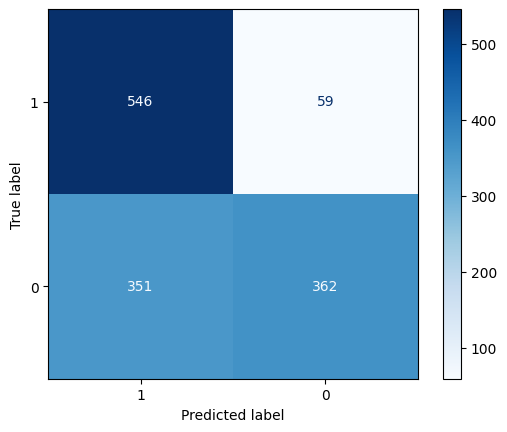

In [24]:
# Evaluate the Naive Bayes classifier on the test data
y_pred_mnb, yhat_mnb, fpr_mnb, tpr_mnb, auc_mnb = inference(classifier_mnb, x_test, y_test)

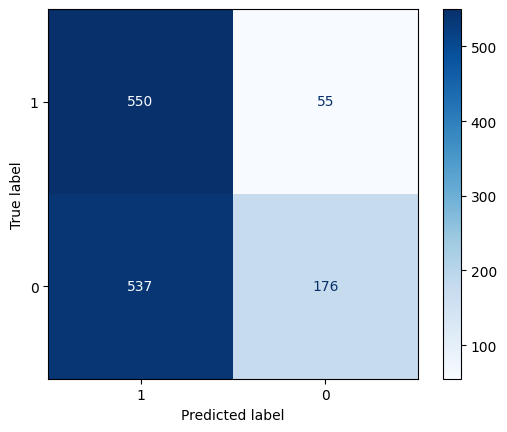

In [25]:
# Evaluate the Naive Bayes classifier on the test data
y_pred_nb, yhat_nb, fpr_nb, tpr_nb, auc_nb = inference(classifier_nb, x_test, y_test)

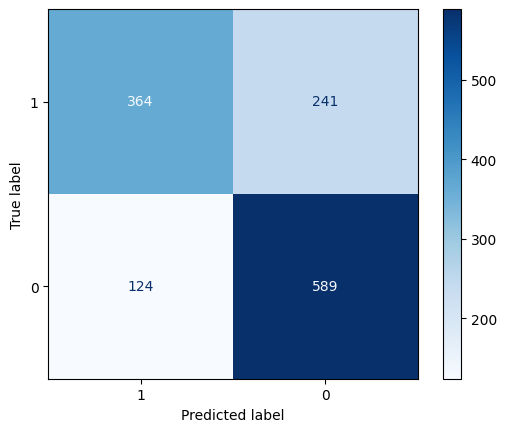

In [26]:
# Evaluate the Decision Tree classifier on the test data
y_pred_dt, yhat_dt, fpr_dt, tpr_dt, auc_dt = inference(classifier_dt, x_test, y_test)

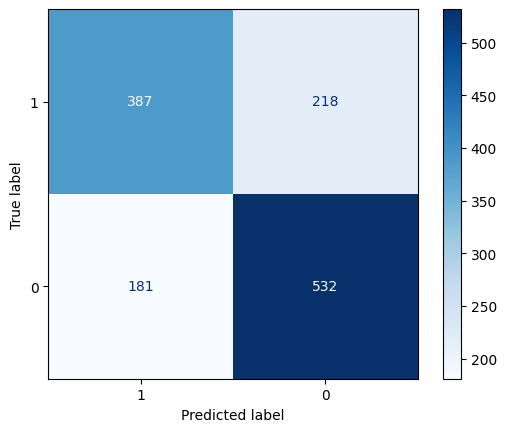

In [27]:
# Evaluate the K-Nearest Neighbors classifier on the test data
y_pred_knn, yhat_knn, fpr_knn, tpr_knn, auc_knn = inference(classifier_knn, x_test, y_test)

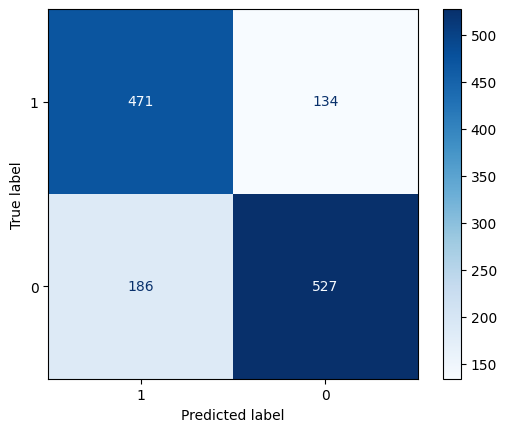

In [28]:
# Evaluate the Logistic Regression classifier on the test data
y_pred_lr, yhat_lr, fpr_lr, tpr_lr, auc_lr = inference(classifier_lr, x_test, y_test)

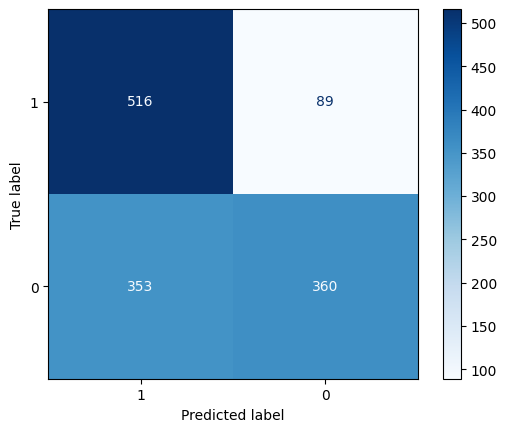

In [29]:
# Evaluate the Random Forest classifier on the test data
y_pred_rf, yhat_rf, fpr_rf, tpr_rf, auc_rf = inference(classifier_rf, x_test, y_test)

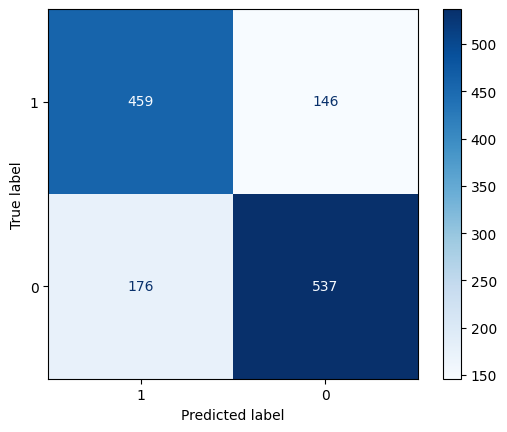

In [30]:
# Evaluate the SVM classifier on the test data
y_pred_svm, yhat_svm, fpr_svm, tpr_svm, auc_svm = inference(classifier_svm, x_test, y_test)

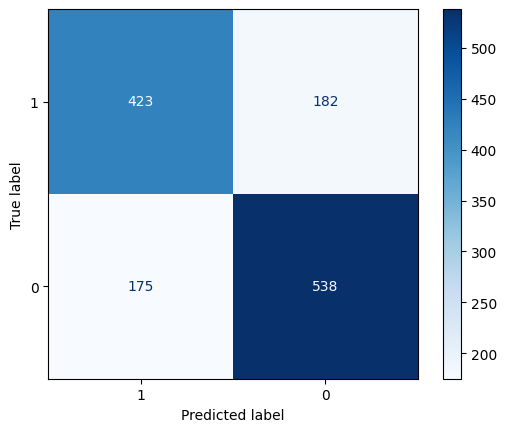

In [31]:
# Evaluate the Random Forest classifier on the test data
y_pred_ada, yhat_ada, fpr_ada, tpr_ada, auc_ada = inference(classifier_ada, x_test, y_test)

### Detailed Metrics for Evaluation

In [32]:
print("------- Machine Learning Results -------")
rf_score = accuracy_score(y_test, y_pred_rf)
knn_score = accuracy_score(y_test, y_pred_knn)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)
mnp_score = accuracy_score(y_test, y_pred_mnb)
np_score = accuracy_score(y_test, y_pred_nb)
svm_score = accuracy_score(y_test, y_pred_svm)
ada_score = accuracy_score(y_test, y_pred_ada)

print ('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('K-Nearest Neighbors Accuracy: ', str(knn_score))
print('F1 score: ', f1_score(y_test, y_pred_knn, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Logistic Regression Accuracy: ',str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Multinomial Naive Bayes Accuracy: ', str(mnp_score))
print('F1 score: ', f1_score(y_test, y_pred_mnb, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Naive Bayes Accuracy: ', str(np_score))
print('F1 score: ', f1_score(y_test, y_pred_nb, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('SVM Accuracy: ', str(svm_score))
print('F1 score: ', f1_score(y_test, y_pred_svm, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('AdaBoost Accuracy: ', str(ada_score))
print('F1 score: ', f1_score(y_test, y_pred_ada, labels = [1,0]))
print ('--' * 20)

------- Machine Learning Results -------
----------------------------------------
Random Forest Accuracy:  0.6646433990895296
F1 score:  0.7001356852103121
----------------------------------------

----------------------------------------
K-Nearest Neighbors Accuracy:  0.697268588770865
F1 score:  0.659846547314578
----------------------------------------

----------------------------------------
Logistic Regression Accuracy:  0.7572078907435509
F1 score:  0.7464342313787639
----------------------------------------

----------------------------------------
Decision Tree Accuracy:  0.7230652503793626
F1 score:  0.6660567246111619
----------------------------------------

----------------------------------------
Multinomial Naive Bayes Accuracy:  0.6889226100151745
F1 score:  0.7270306258322237
----------------------------------------

----------------------------------------
Naive Bayes Accuracy:  0.5508345978755691
F1 score:  0.6501182033096927
----------------------------------------


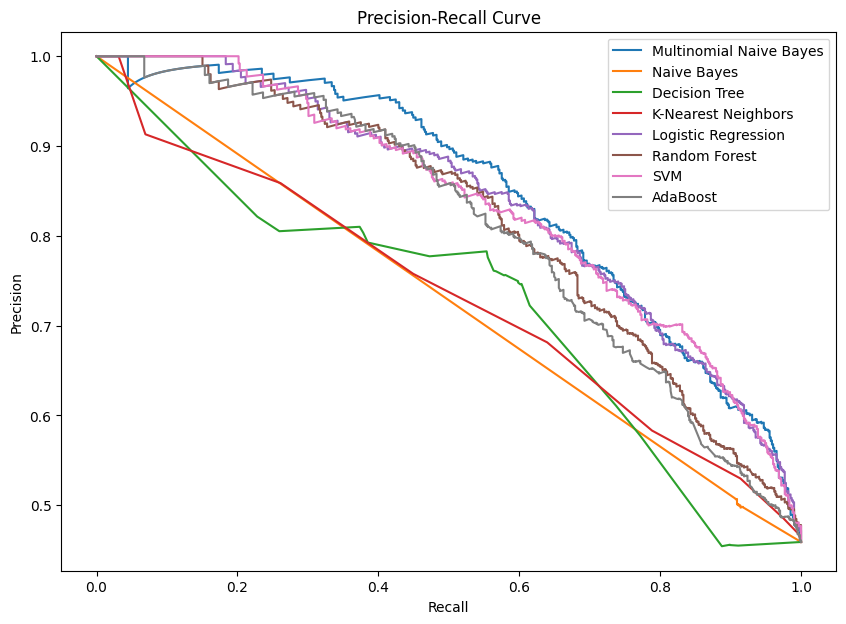

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get prediction scores for each classifier (use `predict_proba` if available, or `decision_function` if it's an SVM)
y_scores_mnp = classifier_mnb.predict_proba(x_test)[:, 1]
y_scores_np = classifier_nb.predict_proba(x_test)[:, 1]
y_scores_dt = classifier_dt.predict_proba(x_test)[:, 1]
y_scores_knn = classifier_knn.predict_proba(x_test)[:, 1]
y_scores_lr = classifier_lr.predict_proba(x_test)[:, 1]
y_scores_rf = classifier_rf.predict_proba(x_test)[:, 1]
y_scores_svm = classifier_svm.decision_function(x_test)
y_scores_ada = classifier_ada.predict_proba(x_test)[:, 1]

# Calculate precision-recall values
prec_mnp, rec_mnp, _ = precision_recall_curve(y_test, y_scores_mnp)
prec_np, rec_np, _ = precision_recall_curve(y_test, y_scores_np)
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_scores_dt)
prec_knn, rec_knn, _ = precision_recall_curve(y_test, y_scores_knn)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_scores_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_scores_rf)
prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_scores_svm)
prec_ada, rec_ada, _ = precision_recall_curve(y_test, y_scores_ada)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
plt.plot(rec_mnp, prec_mnp, label="Multinomial Naive Bayes")
plt.plot(rec_np, prec_np, label="Naive Bayes")
plt.plot(rec_dt, prec_dt, label="Decision Tree")
plt.plot(rec_knn, prec_knn, label="K-Nearest Neighbors")
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.plot(rec_svm, prec_svm, label="SVM")
plt.plot(rec_ada, prec_ada, label="AdaBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

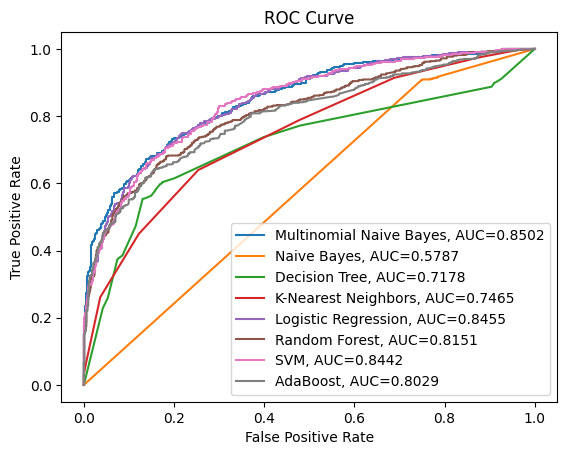

In [34]:
plt.plot(fpr_mnb,tpr_mnb,label="Multinomial Naive Bayes, AUC="+str(auc_mnb))
plt.plot(fpr_nb,tpr_nb,label="Naive Bayes, AUC="+str(auc_nb))
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, AUC="+str(auc_dt))
plt.plot(fpr_knn,tpr_knn,label="K-Nearest Neighbors, AUC="+str(auc_knn))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression, AUC="+str(auc_lr))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, AUC="+str(auc_rf))
plt.plot(fpr_svm,tpr_svm,label="SVM, AUC="+str(auc_svm))
plt.plot(fpr_ada,tpr_ada,label="AdaBoost, AUC="+str(auc_ada))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')

#add legend
plt.legend()

### Inference Using Saved ML-Based Model

In [64]:
import joblib
from sklearn.metrics import classification_report, accuracy_score

# Load the saved model
model = joblib.load('model_svm.pkl')

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(test['label'], y_pred))
print("\nClassification Report:\n", classification_report(test['label'], y_pred))

Accuracy: 0.7556904400606981

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       713
           1       0.72      0.76      0.74       605

    accuracy                           0.76      1318
   macro avg       0.75      0.76      0.75      1318
weighted avg       0.76      0.76      0.76      1318

